In [1]:
import os

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"


import pandas as pd
from pathlib import Path
import time
from collections import defaultdict
from PIL import Image
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import gc
import random
import tensorflow as tf
import plotly.express as px

from tensorflow.keras.applications import ResNet152, ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_recommenders as tfrs
from typing import Dict, Text
from tensorflow.keras import layers
import datetime
from sklearn.preprocessing import StandardScaler
import faiss
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional, Any, Union, Callable, Set, NamedTuple
from dataclasses import dataclass
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder

from dataclasses import dataclass, field
import tensorflow_recommenders as tfrs

from datetime import datetime, timedelta


In [2]:
start_time = time.time()

# Contents

## Section 1
1. Image Embedding

## Section 2
1. Data Loading and Preprocessing Pipeline
2. Train-Test Split
3. Feature Engineering and Preprocessing
4. Model Training 
5. Inference
6. Model Evaluation


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Section 1

## Image Embedding

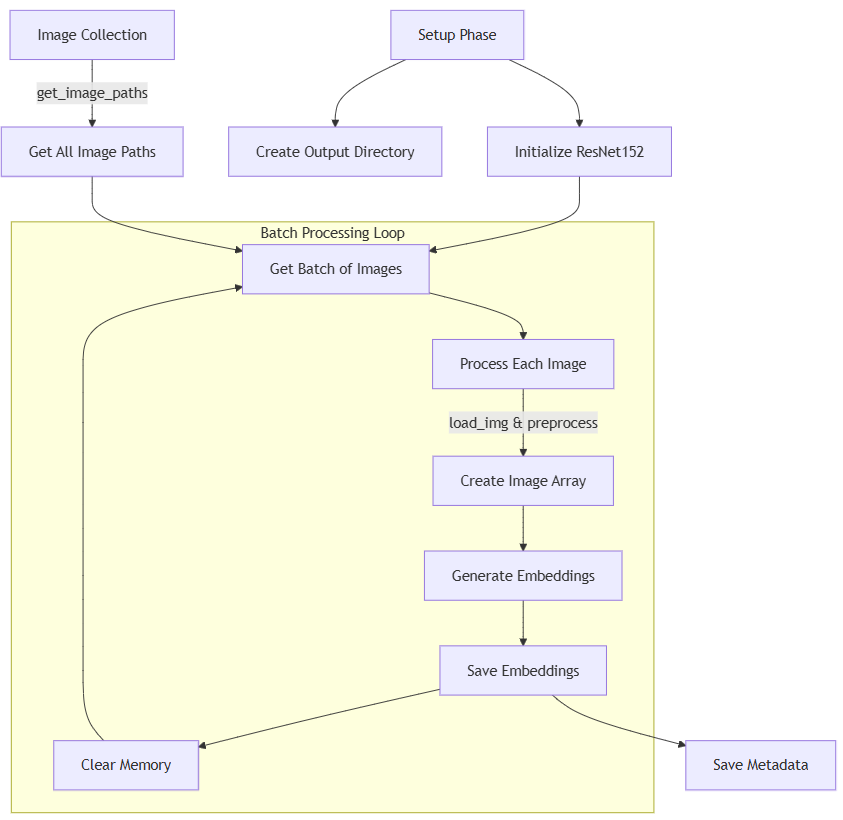

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import ResNet152, ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import tensorflow as tf
import gc
from pathlib import Path

# Constants
IMAGE_DIR = r"my_path\h-and-m-personalized-fashion-recommendations\images"
OUTPUT_DIR = (
    r"my_path\embedded_images_resnet152"
)
MAX_IMAGES = 106_000
BATCH_SIZE = 64

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)


def get_model():
    """
    Get the ResNet model without top layer
    Returns base model that outputs embeddings
    """
    base_model = ResNet152(
        include_top=False, weights="imagenet", pooling="avg"
    )  # 'avg' gives us 2048-dim vector
    return base_model


def process_image(image_path):
    """Load and preprocess single image"""
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None


def get_image_paths():
    """Get all image paths"""
    image_paths = []
    for root, _, files in os.walk(IMAGE_DIR):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
                if len(image_paths) >= MAX_IMAGES:
                    return image_paths
    return image_paths


def embed_images():
    # Check for GPU
    physical_devices = tf.config.list_physical_devices("GPU")
    if physical_devices:
        print("GPU is available")
        # Allow memory growth for GPU
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    else:
        print("No GPU found, using CPU")

    # Get model
    model = get_model()

    # Get image paths
    image_paths = get_image_paths()
    print(f"Found {len(image_paths)} images")

    # Process images in batches
    for i in tqdm(range(0, len(image_paths), BATCH_SIZE)):
        batch_paths = image_paths[i : i + BATCH_SIZE]

        # Process batch
        batch_images = []
        valid_paths = []

        for img_path in batch_paths:
            processed = process_image(img_path)
            if processed is not None:
                # Remove the extra dimension
                batch_images.append(processed[0])  
                valid_paths.append(img_path)

        if not batch_images:
            continue

        # Convert to array and get embeddings
        batch_images = np.array(batch_images)
        batch_embeddings = model.predict(batch_images, verbose=0)

        # Save individual embeddings
        for img_path, embedding in zip(valid_paths, batch_embeddings):
            filename = os.path.basename(img_path)
            output_path = os.path.join(
                OUTPUT_DIR, f"{os.path.splitext(filename)[0]}.npy"
            )
            np.save(output_path, embedding)

        # Clear memory- free up CPU memory
        del batch_images, batch_embeddings
        gc.collect()

    print(f"Embeddings saved to: {OUTPUT_DIR}")



 


## Note to reviewer - Have not run this code in the python ipynb file as it takes a long time to run.


In [ ]:
# Execute the function
embed_images()

In [ ]:
#Output of one embedding

# Directory path
dir_path = r"my_path\Project\embedded_images_resnet152"

# Get a random .npy file
npy_files = [f for f in os.listdir(dir_path) if f.endswith('.npy')]
random_file = random.choice(npy_files)

# Load the embedding
embedding_path = os.path.join(dir_path, random_file)
embedding = np.load(embedding_path)

print(f"File name: {random_file}")
print(f"Embedding shape: {embedding.shape}")
print("Values of embedding:", embedding)

File name: 0650939001.npy
Embedding shape: (2048,)
Values of embedding: [0.        0.        0.0592963 ... 0.        0.        0.       ]


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Section 2

# Data Loading and Preprocessing Pipeline

The data pipeline processes H&M's fashion retail dataset through three main stages:

1. Initial Data Loading:
Here we read input csv's and save them in a dictionary, and the dictionaries into a picke file. This is done to ssave time on subsequent data loads- we only need to load the pickle file from then on (if it exists). Loading pickle file is faster . This handles transaction records, customer information, and article details.

2. Data Type Management:
Ensures consistent data types across datasets, with careful handling of IDs, categorical variables, and missing values. Particular attention is paid to customer data integrity.

3. Dataset Filtering:
Processes the most recent N images (defined by us) transactions while maintaining referential integrity between customer and article datasets. Optionally incorporates article image embeddings for enhanced feature representation.

In [ ]:
def format_number(n):
    """Format number with commas after every 3 digits"""
    return f"{n:,}"


def read_csvs_to_dict(directory_path: str) -> Dict[str, pd.DataFrame]:
    """
    Read all CSV files from a directory into a dictionary where
    keys are filenames and values are pandas DataFrames
    """
    dir_path = Path(directory_path)
    # Dictionary to store dfs
    csv_dict = {}

        
    try:
        # Iterate through all files in directory
        for file_path in dir_path.glob("*.csv"):
            try:
                
                df = pd.read_csv(file_path)

                # Use stem (filename without extension) as key
                key = file_path.stem


                csv_dict[key] = df

                print(f"Successfully read: {file_path.name}")
                # print(f"Shape: {df.shape}")

            except Exception as e:
                print(f"Error reading {file_path.name}: {str(e)}")

        if not csv_dict:
            print("No CSV files found in the directory")

        return csv_dict

    except Exception as e:
        print(f"Error accessing directory: {str(e)}")
        return {}


def main_load_raw():

    directory = r"my_pathg\Project\h-and-m-personalized-fashion-recommendations"
    data_dict = read_csvs_to_dict(directory)

    # Print summary of loaded data
    print("\nSummary of loaded data:")
    for filename, df in data_dict.items():
        print(f"\nFilename: {filename}")
        print(
            f"Dimensions: ({format_number(df.shape[0])}, {format_number(df.shape[1])})"
        )
        print("Columns:", list(df.columns))
        print("Memory usage:", f"{df.memory_usage().sum() / 1024**2:.2f} MB")
    
    for filename, df in data_dict.items():
        print(f"\nFilename: {filename} \n **********************************")

        df[
            [
                col
                for col in df.columns
                if any(sub in col for sub in ["id", "code", "name", "no"])
            ]
        ] = df[
            [
                col
                for col in df.columns
                if any(sub in col for sub in ["id", "code", "name", "no"])
            ]
        ].astype(str)

        if filename == "customers":
            df[["FN", "Active"]] = df[["FN", "Active"]].fillna(0).astype(float)

        print(df.dtypes)

    return data_dict

def load_data(pkl_file="data_dict2.pkl"):
    """
    Load data from pkl file
    """

    if os.path.exists(pkl_file):
        print("Loading data_dict from pkl file...")
        with open(pkl_file, "rb") as f:
            data_dict = pickle.load(f)
            print(f"Loaded data_dict from {pkl_file}")
    else:
        print("No pkl file found. Loading raw data...")
        data_dict = main_load_raw()
        with open(pkl_file, "wb") as f:
            pickle.dump(data_dict, f)
            print(f"Saved data_dict to {pkl_file}")

    return data_dict

def filter_datasets(
    data_dict: Dict[str, pd.DataFrame],
    include_article_embeddings: bool = True,
    article_embedding_path: str = r"my_path\\article_embeddings.parquet",
):
    """
    Filter datasets to include only transactions, customers, and articles

    """
    transactions_df = data_dict["transactions_train"]
    customers_df = data_dict["customers"]
    articles_df = data_dict["articles"]
    # print(f"article_id dtype = {articles_df['article_id'].dtype}")
    if include_article_embeddings:
        print("Including article embeddings")
        article_embedding_df = pd.read_parquet(article_embedding_path)
        # print(f"article_id article_embedding_df dtype = {article_embedding_df['article_id'].head()}")

        articles_df = pd.merge(
            articles_df, article_embedding_df, on="article_id", how="left"
        )

    transactions_df["t_dat"] = pd.to_datetime(transactions_df["t_dat"])
    transactions_df = transactions_df.sort_values("t_dat")
    transactions_df = transactions_df.tail(50_000)


    unique_customers, unique_items = (
        transactions_df["customer_id"].unique(),
        transactions_df["article_id"].unique(),
    )

    customers_df = customers_df.loc[customers_df["customer_id"].isin(unique_customers)]
    articles_df = articles_df.loc[articles_df["article_id"].isin(unique_items)]

    return transactions_df, customers_df, articles_df

In [4]:


def merge_list_of_datasets(list_of_article_datasets: List[pd.DataFrame]) -> pd.DataFrame:
    """
    Prepare data for inference- This is customized for our use case
    """
    return pd.concat(list_of_article_datasets, ignore_index=True)

In [ ]:
#Load data
data_dict = load_data()

Loading data_dict from pkl file...
Loaded data_dict from data_dict2.pkl


In [6]:
print(f"data_dict keys: {data_dict.keys()} \n customer df shape: {data_dict['customers'].shape} \n transactions df shape: {data_dict['transactions_train'].shape} \n articles df shape: {data_dict['articles'].shape}")

data_dict keys: dict_keys(['articles', 'article_embeddings', 'customers', 'sample_submission', 'transactions_train']) 
 customer df shape: (1371980, 7) 
 transactions df shape: (31788324, 5) 
 articles df shape: (105542, 25)


In [ ]:
# Filter datasets
transactions_df, customers_df, articles_df = filter_datasets(data_dict, include_article_embeddings=True)

Including article embeddings


In [71]:
customers_df.head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
86,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,ACTIVE,Regularly,33.0,d647e4ede3d0eb4ce0750440a110350b5f4c758165d89d...
107,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0.0,0.0,ACTIVE,NONE,29.0,72afbb92c0200628bfa8f983c241eb0dc14e107f87d95b...
117,000525e3fe01600d717da8423643a8303390a055c578ed...,1.0,1.0,ACTIVE,Regularly,25.0,ed323346483de9f9b9ac7d73d34e0c87b5946d09da3b07...
179,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,0.0,0.0,ACTIVE,NONE,23.0,3119ea10ffe5ac3419b9127589a61b33e1ae38ecbb997b...
330,000fb6e772c5d0023892065e659963da90b1866035558e...,1.0,1.0,ACTIVE,Regularly,42.0,68ca4d9d6051d9c10b917d36bf9cb4afbadc551f7e4feb...


In [72]:
articles_df.head(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,pca_246,pca_247,pca_248,pca_249,pca_250,pca_251,pca_252,pca_253,pca_254,pca_255
6,111565001,111565,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,111586001,111586,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,111593001,111593,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,111609001,111609,200 den 1p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,123173001,123173,Control Top 50 den 1p Tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
transactions_df.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id
31751190,2020-09-21,de7d958d43387fe0fb31e00e244d44a7f95b02f01298de...,928917003,0.042356,2
31751128,2020-09-21,ddd86f4827da2c1ae3abb18a6ef1ba6f32a88766be50dd...,924243002,0.040831,2
31751126,2020-09-21,ddd86f4827da2c1ae3abb18a6ef1ba6f32a88766be50dd...,902528007,0.049000,2
31751093,2020-09-21,dd888f31fc94d275bbf6c83068647066ef324697929862...,831302001,0.033881,2
31751092,2020-09-21,dd836ea128a17bef8cd0c70478ecfe9d0ed07fa4a84c66...,456163086,0.033881,2


# Train-Test Split

We implemented a temporal split that respects the chronological nature of purchases. This means we train on older data and test on newer data, mimicking how the system would work in real life. This approach helps us better understand how our model will perform with future purchases and seasonal trends.

In [8]:

def create_temporal_split_percentage(transactions_df, train_size=0.70, val_size=0.15):
    """
    Create time based train test split

    """
    # Sorting transactions by the date
    sorted_df = transactions_df.sort_values('t_dat').reset_index(drop=True)
    
    # Getting index positions based on train and val sizes
    n_transactions = len(sorted_df)
    train_end_idx = int(n_transactions * train_size)
    val_end_idx = int(n_transactions * (train_size + val_size))
    
    # splitting df based on index values
    train_df = sorted_df.iloc[:train_end_idx].copy()
    print(f"\nTrain period: {train_df['t_dat'].min()} to {train_df['t_dat'].max()}")
    print(f"Train shape: {train_df.shape}")

    val_df = sorted_df.iloc[train_end_idx:val_end_idx].copy()
    print(f"Validation shape: {val_df.shape}") 

    test_df = sorted_df.iloc[val_end_idx:].copy()
    print(f"Test shape: {test_df.shape}")



       
        
    return train_df, val_df, test_df



In [9]:
# Train test split
train_df, val_df, test_df = create_temporal_split_percentage(transactions_df)


Train period: 2020-09-21 00:00:00 to 2020-09-22 00:00:00
Train shape: (35000, 5)
Validation shape: (7500, 5)
Test shape: (7500, 5)


# Feature Engineering and Preprocessing

We built the feature engineering pipeline with two main parts to transform raw transaction data into meaningful features for our recommendation model:

1. Feature Engineering (`FeatureEngineer`):
  - Transforms customer data into useful metrics like purchasing frequency, average spend, and recent activity
  - Creates article features showing how popular items are, their typical prices, and sales patterns
  - Adds time-based features from transactions like day of week and seasonal patterns

2. Feature Preprocessing (`FeaturePreprocessor`):
  - Handles different types of data (numbers, categories, IDs) appropriately
  - Scales numerical features so they're comparable
  - Converts categorical features into a format the model can understand
  - Takes care of missing data and memory optimization
  - Ensures consistent processing across training and test data

The main function ties everything together, making sure each dataset (train, validation, test) is processed consistently while keeping their time-based separation intact.

In [10]:


class FeatureEngineer:
    """ 
    This class does feature engineering - for cutomers, articles and transactions
    """
    def __init__(
        self,transactions_train,transactions_val,transactions_test,
        articles_df,
        customers_df):

        self.transactions_train = transactions_train
        self.transactions_val = transactions_val
        self.transactions_test = transactions_test
        self.articles_df = articles_df
        self.customers_df = customers_df

    def engineer_customer_features(
        self,
        transactions_df,
        end_date: datetime,
        cols_to_drop = ["postal_code","first_purchase","last_purchase"]):
        """
        Engineer customer features
        """

        hist_transactions = transactions_df[transactions_df["t_dat"] <= end_date]

        #Get dae,price and article metrics for each customer
        customer_features = pd.DataFrame()
        customer_stats = (
            hist_transactions.groupby("customer_id")
            .agg({
                    "t_dat": ["count", "min", "max"],
                    "price": ["mean", "std", "min", "max", "sum"],
                    "article_id": "nunique",
                    "sales_channel_id": lambda x: x.value_counts().index[0],
                }).reset_index())

        customer_stats.columns = [
            "customer_id","purchase_count","first_purchase","last_purchase","avg_price","price_std","min_price","max_price","total_spend","unique_items","preferred_channel",
            ]

        # Calculate customer activity measures
        customer_stats["days_active"] = (
            customer_stats["last_purchase"] - customer_stats["first_purchase"]
        ).dt.days
        customer_stats["purchase_frequency"] = customer_stats["purchase_count"] / (
            customer_stats["days_active"] + 1
        )

        last_month = end_date - timedelta(days=30)
        recent_transactions = hist_transactions[hist_transactions["t_dat"] > last_month]
        recent_stats = (
            recent_transactions.groupby("customer_id")
            .agg({"t_dat": "count", "price": ["mean", "sum"]})
            .reset_index()
        )

        recent_stats.columns = [
            "customer_id","recent_purchases","recent_avg_price","recent_spend",]

        # Merge all customer features
        customer_features = customer_stats.merge(
            recent_stats, on="customer_id", how="left"
        )
        customer_features = customer_features.merge(
            self.customers_df, on="customer_id", how="left"
        )

        # Fill NAs
        customer_features = customer_features.fillna(
            {"recent_purchases": 0, "recent_avg_price": 0, "recent_spend": 0}
        )

        customer_features = self.handle_nulls(customer_features)
        # Drop columns
        for col in cols_to_drop:
            customer_features = customer_features.drop(col, axis=1, errors="ignore")

        #Add suffix to column names
        customer_features.columns = ['customer_id'] + [f"{col}_cust" for col in customer_features.columns if col != 'customer_id']

        return customer_features

    def engineer_article_features(
        self,
        transactions_df,
        end_date: datetime,cols_to_drop= [
            "product_code","prod_name","product_type_no","graphical_appearance_no","colour_group_code",
            "perceived_colour_value_id","perceived_colour_master_id","department_no","department_name","index_code",
            "index_group_no","section_no","garment_group_no","detail_desc","first_sale","last_sale",]
    ) :
        """
        Engineer article features 
        """
        # Filter transactions up to end_date
        hist_transactions = transactions_df[transactions_df["t_dat"] <= end_date]

        # Basic popularity metrics
        article_features = pd.DataFrame()
        article_stats = (
            hist_transactions.groupby("article_id")
            .agg({    "t_dat": ["count", "min", "max"],
                    "customer_id": "nunique",
                    "price": ["mean", "std", "median"],
                    "sales_channel_id": lambda x: x.value_counts().index[0],
                }).reset_index()
        )

        article_stats.columns = [
            "article_id","total_sales","first_sale","last_sale","unique_customers","avg_price","price_std","median_price","preferred_channel",]

        # Recent popularity
        last_month = end_date - timedelta(days=30)
        recent_transactions = hist_transactions[hist_transactions["t_dat"] > last_month]
        recent_stats = (
            recent_transactions.groupby("article_id")
            .agg({"t_dat": "count", "customer_id": "nunique"})
            .reset_index()
        )

        recent_stats.columns = ["article_id", "recent_sales", "recent_unique_customers"]

        # Merge with article metadata
        article_features = article_stats.merge(
            recent_stats, on="article_id", how="left"
        )
        article_features = article_features.merge(
            self.articles_df, on="article_id", how="left"
        )

        # Fill NAs
        article_features = article_features.fillna(
            {"recent_sales": 0, "recent_unique_customers": 0}
        )

        article_features = self.handle_nulls(article_features)
        # Drop columns
        for col in cols_to_drop:
            article_features = article_features.drop(col, axis=1, errors="ignore")
        # article_features = article_features.drop(cols_to_drop, inplace=True)

        #Add suffix to column names
        article_features.columns = ['article_id'] + [f"{col}_art" for col in article_features.columns if col != 'article_id']

        return article_features

    def engineer_interaction_features(
        self, transactions_df: pd.DataFrame
    ) :
        """
        Engineer features for each transaction
        """
        interactions = transactions_df.copy()

        # Time-based features
        interactions["day_of_week"] = interactions["t_dat"].dt.dayofweek
        interactions["month"] = interactions["t_dat"].dt.month
        interactions["day"] = interactions["t_dat"].dt.day
        interactions["is_weekend"] = (
            interactions["day_of_week"].isin([5, 6]).astype(int)
        )

        interactions = self.handle_nulls(interactions)

        # # Convert all float columns to float32
        # interactions = interactions.select_dtypes(include=['float64']).astype('float32')
        # # Convert all int columns to int32
        # interactions = interactions.select_dtypes(include=['int64']).astype('int32')

        return interactions

    def create_all_features(self, target_df, reference_date=None):
        """
        Create all features for a given dataset
        """
        if reference_date is None:
            reference_date = target_df["t_dat"].max()

        # Run all above functions for respective datasets
        customer_features = self.engineer_customer_features(
            self.transactions_train, reference_date
        )
        article_features = self.engineer_article_features(
            self.transactions_train, reference_date
        )
        interaction_features = self.engineer_interaction_features(target_df)

        # Merge all features
        final_features = interaction_features.merge(
            customer_features, on="customer_id", how="left"
        ).merge(article_features, on="article_id", how="left")

        return final_features

    def handle_nulls(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Handle nulls
        """
        # print("\nNull counts before handling:")
        # print(df.isnull().sum())

        for col in df.columns:
            # Skip if no nulls
            if df[col].isnull().sum() == 0:
                continue

            # Check if numerical
            if pd.api.types.is_numeric_dtype(df[col]):
                # Check if binary 
                if df[col].nunique() <= 2:
                    df[col] = df[col].fillna(0)
                # continuous 
                else:
                    df[col] = df[col].fillna(df[col].median())
            # Categorical
            else:
                df[col] = df[col].fillna(df[col].mode()[0])

        print("\nNull counts handling Done")
        # print(df.isnull().sum())

        return df



In [11]:


class FeaturePreprocessor:
    """ 
    This class scales ad enncodes numerical and categorical features
    """
    def __init__(self):
        """Initialize variables that we ill use later on for scaling and encoding"""
        
        self.continuous_scaler = StandardScaler()
        self.categorical_encoders = {}  # Dictionary to store encoder for each categorical feature
        self.id_encoders = {}  # Dictionary to store encoders for ID columns
        self.continuous_features = None
        self.binary_features = None
        self.categorical_features = None
        self.fitted = False
    
    def _detect_feature_types(self, df):
        """
        This is a helper function that automatically detect feature types from dataframe
        Returns lists of continuous, binary, and categorical features - to be used later in other fnctuions
        """
        continuous = []
        binary = []
        categorical = []
        
        for col in df.columns:
            # Skip ID columns and datetime
            if 'id' in col.lower() or 'label' in col.lower():
                print(f"Skipping ID/Label column: {col}")
                continue
            if df[col].dtype == 'datetime64[ns]':
                print(f"Skipping datetime column: {col}")
                continue
                
            # If numerical
            if pd.api.types.is_numeric_dtype(df[col]):
                # If binary 
                if df[col].nunique() <= 2:
                    binary.append(col)
                else:
                    continuous.append(col)
            # If not numerical, treat as categorical
            else:
                categorical.append(col)
        
        return continuous, binary, categorical
    
    def fit(self, df):
        """
        Fit transformers on training data and store feature lists
        """

        # Fit ID encoders first
        for id_col in df.columns:
            if id_col == "customer_id":
                unique_values = df[id_col].fillna('unknown').unique()
                id_to_index = {val: idx for idx, val in enumerate(unique_values)}
                self.id_encoders[id_col] = {
                    "mapping": id_to_index,
                     # Map unseen values to this index
                    "default": len(id_to_index) 
                }
                print(f"\nFitted encoder for {id_col}, found {len(unique_values)} unique values.")

        # Detect feature types
        self.continuous_features, self.binary_features, self.categorical_features = self._detect_feature_types(df)
        
        print("\nDetected Features:")
        print(f"Continuous: {self.continuous_features}")
        print(f"Binary: {self.binary_features}")
        print(f"Categorical: {self.categorical_features}")
        
        # Fit continuous cols
        if self.continuous_features:
            self.continuous_scaler.fit(df[self.continuous_features])
            
        # Fit separate encoder for each categorical cols
        if self.categorical_features:
            for cat_feature in self.categorical_features:
                encoder = OneHotEncoder(handle_unknown='ignore')
                encoder.fit(df[[cat_feature]])
                self.categorical_encoders[cat_feature] = encoder
        
        self.fitted = True
        print("\nPreprocessor Fitted")

        return self
    
    def transform(self, df):

        
        result_df = df.copy()

        # Transform ID columns
        for id_col, encoder in self.id_encoders.items():
            mapping = encoder["mapping"]
            default_value = encoder["default"]
            result_df[f"{id_col}"] = df[id_col].fillna('unknown').map(mapping).fillna(-1).astype(int)


        # Transform continuous cols
        if self.continuous_features:
            result_df[self.continuous_features] = self.continuous_scaler.transform(df[self.continuous_features])
            print("\nContinuous features transformed")
        
        if self.categorical_features:
            for cat_feature in self.categorical_features:
                encoder = self.categorical_encoders[cat_feature]
                # Convert sparse matrix to array
                encoded_features = encoder.transform(df[[cat_feature]]).toarray() 
                categories = encoder.categories_[0]
                feature_names = [f"{cat_feature}_{category}" for category in categories]
                
                encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=df.index)
                result_df = result_df.drop(columns=[cat_feature])
                result_df = pd.concat([result_df, encoded_df], axis=1)
        
        # Convert all float columns to float32
        # result_df = result_df.select_dtypes(include=['float64']).astype('float32')
        float64_cols = result_df.select_dtypes(include=['float64']).columns
        result_df[float64_cols] = result_df[float64_cols].astype('float32')
        # Convert all int columns to int32
        # result_df = result_df.select_dtypes(include=['int64']).astype('int32')
        int64_cols = result_df.select_dtypes(include=['int64']).columns
        result_df[int64_cols] = result_df[int64_cols].astype('int32')
        
        return result_df
    
    def fit_transform(self, df):
        """Fit transformers and transform data"""
        return self.fit(df).transform(df)

    def get_feature_names(self):
        """
        Get list of all features after transformation
        """
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted before getting feature names")

        feature_names = []

        # Add continuous and binary features
        feature_names.extend(self.continuous_features)
        feature_names.extend(self.binary_features)

        # Add encoded categorical feature names
        if self.categorical_features:
            feature_names.extend(
                self.categorical_encoder.get_feature_names_out(
                    self.categorical_features
                )
            )

        return feature_names
    
    def inverse_transform_ids(self, encoded_ids, id_column):
        """
        Convert encoded IDs back to original IDs

        """
        if id_column not in self.id_encoders:
            raise ValueError(f"No encoder found for {id_column}")
        
        return self.id_encoders[id_column].inverse_transform(encoded_ids)



In [12]:
def main_feature_engineering(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    articles_df: pd.DataFrame,
    customers_df: pd.DataFrame,
    scale_and_encode: bool = True,
) -> Dict[str, pd.DataFrame]:
    """
    Main function to execute feature engineering and preprocessing
    """
    # Initialize feature engineer
    fe = FeatureEngineer(train_df, val_df, test_df, articles_df, customers_df)

    # Get reference dates for each split
    train_end_date = train_df["t_dat"].max()
    val_end_date = val_df["t_dat"].max()
    test_end_date = test_df["t_dat"].max()

    # Create customer features (separate for each split)
    customer_features_train = fe.engineer_customer_features(train_df, train_end_date)
    customer_features_val = fe.engineer_customer_features(val_df, val_end_date)
    customer_features_test = fe.engineer_customer_features(test_df, test_end_date)

    # Similarly for article features
    article_features_train = fe.engineer_article_features(train_df, train_end_date)
    article_features_val = fe.engineer_article_features(val_df, val_end_date)
    article_features_test = fe.engineer_article_features(test_df, test_end_date)

    # print(f"************************************ {article_features_train.columns}")

    # Create interaction features
    train_interactions = fe.engineer_interaction_features(train_df)
    val_interactions = fe.engineer_interaction_features(val_df)
    test_interactions = fe.engineer_interaction_features(test_df)

    # Initialize preprocessors for each type
    if scale_and_encode:
        print("Scaling and encoding features...")
        customer_preprocessor = FeaturePreprocessor()
        article_preprocessor = FeaturePreprocessor()
        interaction_preprocessor = FeaturePreprocessor()

        # Fit and transform train data, then transform val and test
        customer_features_train = customer_preprocessor.fit_transform(
            customer_features_train
        )
        customer_features_val = customer_preprocessor.transform(customer_features_val)
        customer_features_test = customer_preprocessor.transform(customer_features_test)

        #2
        article_features_train = article_preprocessor.fit_transform(
            article_features_train
        )
        article_features_val = article_preprocessor.transform(article_features_val)
        article_features_test = article_preprocessor.transform(article_features_test)

        #3
        train_interactions = interaction_preprocessor.fit_transform(train_interactions)
        # print("************************************",train_interactions.dtypes)
        val_interactions = interaction_preprocessor.transform(val_interactions)
        test_interactions = interaction_preprocessor.transform(test_interactions)



        print("Features scaled and encoded successfully!")

    print("\nFeature Engineering and Preprocessing Summary:")
    print(
        f"Customer features shape - Train: {customer_features_train.shape}, Val: {customer_features_val.shape}, Test: {customer_features_test.shape}"
    )
    print(
        f"Article features shape - Train: {article_features_train.shape}, Val: {article_features_val.shape}, Test: {article_features_test.shape}"
    )
    print(
        f"Interaction features shape - Train: {train_interactions.shape}, Val: {val_interactions.shape}, Test: {test_interactions.shape}"
    )

    if not scale_and_encode:

        return {
            "customer_features": {
                "train": customer_features_train,
                "val": customer_features_val,
                "test": customer_features_test,
            },
            "article_features": {
                "train": article_features_train,
                "val": article_features_val,
                "test": article_features_test,
            },
            "interactions": {
                "train": train_interactions,
                "val": val_interactions,
                "test": test_interactions,
            },
        }
    else:
        return {
            "customer_features": {
                "train": customer_features_train,
                "val": customer_features_val,
                "test": customer_features_test,
            },
            "article_features": {
                "train": article_features_train,
                "val": article_features_val,
                "test": article_features_test,
            },
            "interactions": {
                "train": train_interactions,
                "val": val_interactions,
                "test": test_interactions,
            },
            "preprocessors": {
                "customer": customer_preprocessor,
                "article": article_preprocessor,
                "interaction": interaction_preprocessor,
            },
        }

In [59]:
# Feature engineering
feature_engineered_df_dict = main_feature_engineering(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    articles_df=articles_df,
    customers_df=customers_df,
    scale_and_encode=True,
)


Null counts handling Done

Null counts handling Done

Null counts handling Done

Null counts handling Done

Null counts handling Done

Null counts handling Done

Null counts handling Done

Null counts handling Done

Null counts handling Done
Scaling and encoding features...

Fitted encoder for customer_id, found 10926 unique values.
Skipping ID/Label column: customer_id

Detected Features:
Continuous: ['purchase_count_cust', 'avg_price_cust', 'price_std_cust', 'min_price_cust', 'max_price_cust', 'total_spend_cust', 'unique_items_cust', 'purchase_frequency_cust', 'recent_purchases_cust', 'recent_avg_price_cust', 'recent_spend_cust', 'age_cust']
Binary: ['days_active_cust', 'FN_cust', 'Active_cust']
Categorical: ['preferred_channel_cust', 'club_member_status_cust', 'fashion_news_frequency_cust']

Preprocessor Fitted

Continuous features transformed

Continuous features transformed

Continuous features transformed
Skipping ID/Label column: article_id

Detected Features:
Continuous: ['tot

In [ ]:
# Extract DataFrames from the dictionary
customer_train, customer_val, customer_test = (
    feature_engineered_df_dict["customer_features"]["train"],
    feature_engineered_df_dict["customer_features"]["val"],
    feature_engineered_df_dict["customer_features"]["test"],
)
article_train, article_val, article_test = (
    feature_engineered_df_dict["article_features"]["train"],
    feature_engineered_df_dict["article_features"]["val"],
    feature_engineered_df_dict["article_features"]["test"],
)
interactions_train, interactions_val, interactions_test = (
    feature_engineered_df_dict["interactions"]["train"],
    feature_engineered_df_dict["interactions"]["val"],
    feature_engineered_df_dict["interactions"]["test"],
)

In [76]:
interactions_train.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,day_of_week,month,day,is_weekend
0,2020-09-21,0,928917003,0.335712,2,0,9,21,0
1,2020-09-21,1,888927001,0.335712,2,0,9,21,0
2,2020-09-21,2,456163087,-0.047528,2,0,9,21,0
3,2020-09-21,2,456163087,-0.047528,2,0,9,21,0
4,2020-09-21,3,897108001,0.335712,2,0,9,21,0


In [74]:
customer_train.head(5)

,customer_id,purchase_count_cust,avg_price_cust,price_std_cust,min_price_cust,max_price_cust,total_spend_cust,unique_items_cust,days_active_cust,purchase_frequency_cust,...,Active_cust,age_cust,preferred_channel_cust_1,preferred_channel_cust_2,club_member_status_cust_ACTIVE,club_member_status_cust_LEFT CLUB,club_member_status_cust_PRE-CREATE,fashion_news_frequency_cust_Monthly,fashion_news_frequency_cust_NONE,fashion_news_frequency_cust_Regularly
0,0,-0.703311,0.290571,-0.170591,0.600525,-0.083157,-0.558446,-0.728572,0,-0.714627,...,1.0,-0.185366,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,-0.064915,0.290571,-0.170591,0.210888,0.217484,0.121788,0.052470,0,-0.047973,...,0.0,-0.465589,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,-0.703311,-0.500013,-0.170591,-0.178750,-0.684437,-0.694547,-0.728572,0,-0.714627,...,1.0,-0.745811,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3,2.807867,-0.177191,0.089508,-0.581635,0.186217,2.216520,3.567159,0,2.951967,...,0.0,-0.885922,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,-0.064915,0.027043,-0.548003,0.210888,-0.083157,-0.014314,-0.338051,0,-0.047973,...,1.0,0.445135,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [75]:
article_train.head(5)

,article_id,total_sales_art,unique_customers_art,avg_price_art,price_std_art,median_price_art,recent_sales_art,recent_unique_customers_art,pca_0_art,pca_1_art,...,garment_group_name_art_Shorts,garment_group_name_art_Skirts,garment_group_name_art_Socks and Tights,garment_group_name_art_Special Offers,garment_group_name_art_Swimwear,garment_group_name_art_Trousers,garment_group_name_art_Trousers Denim,"garment_group_name_art_Under-, Nightwear",garment_group_name_art_Unknown,garment_group_name_art_Woven/Jersey/Knitted mix Baby
0,111565001,0.913957,0.657125,-1.038597,0.694240,-1.005313,0.913957,0.657125,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,111586001,-0.446795,-0.446451,-0.594894,-0.244581,-0.599554,-0.446795,-0.446451,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,111593001,-0.310720,-0.288797,-0.709581,1.229045,-0.713535,-0.310720,-0.288797,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,111609001,-0.310720,-0.288797,-0.850144,1.573964,-0.853233,-0.310720,-0.288797,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,123173001,1.050032,0.341818,-0.757553,0.509910,-0.801481,1.050032,0.341818,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Architecture and Training
## Two-Stage Recommendation System Architecture

Our fashion recommendation system operates in two parallel stages:

1. Retrieval Stage:
   - Customer Tower: Maps customer features to 32-dim embeddings using dense layers (128→64→32)
   - Item Tower: Maps article features to same embedding space
   - Purpose: Quickly finds potential matches by comparing embeddings
   - Uses temperature-scaled similarity scoring (0.1)

2. Ranking Stage:
   - Processes full customer and article features independently
   - Each branch uses dense layers (64→32)
   - Concatenates processed features
   - Final layers (32→16→1) with sigmoid for purchase probability
   - Trains alongside retrieval, not sequentially

Training Process:
- Both models train simultaneously with combined loss
- Uses negative sampling (4 negative examples per positive)
- Tracks multiple metrics: AUC, Precision, Recall
- Adam optimizer with 0.001 learning rate
- Visualizes training progress through loss and metric plots

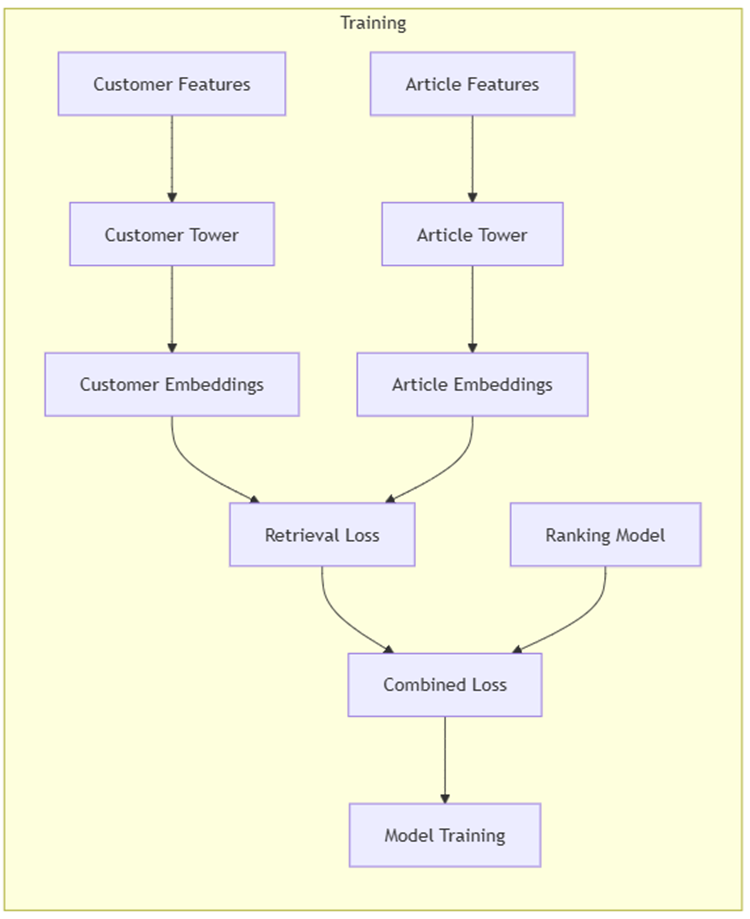

In [61]:

@dataclass
class DataConfig:
    """Configuration for feature dimensions and model parameters."""

    # Field here refers to defualt dataclass attributes 
    customer_df: pd.DataFrame = field(repr=False)
    article_df: pd.DataFrame = field(repr=False)
    customer_feature_dim: int = field(init=False)
    article_feature_dim: int = field(init=False)

    # Define neural network parameters
    embedding_dim: int = 32
    hidden_dims: Tuple[int, ...] = (128, 64)
    temperature: float = 0.1

    def __post_init__(self) -> None:
        """Calculate feature dimensions after initialization."""

        #FIlter customer df for customer features
        self.customer_feature_dim = len(
            self.customer_df.filter(regex=".*_cust$|.*_cust_.*").columns
        )

        #Filter article df for article features
        self.article_feature_dim = len(self.article_df.filter(regex=".*_art$|.*_art_.*").columns)
        print(f"Customer features dimension: {self.customer_feature_dim}")
        print(f"Article features dimension: {self.article_feature_dim}")


class CustomerTower(tf.keras.Model):
    """Encodes customer features into embeddings."""

    def __init__(
        self,
        #   feature_dim: int,
        embedding_dim: int,
        hidden_dims: Tuple[int, ...],
        input_dim: int,
    ) -> None:
        """Initialize the query encoder/Customer Tower.
        """
        super().__init__()

        self.sequential = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(input_dim,))]
            + [tf.keras.layers.Dense(units, activation="relu") for units in hidden_dims]
            + [
                tf.keras.layers.Dense(embedding_dim),
                tf.keras.layers.LayerNormalization(),
            ]
        )

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        return self.sequential(inputs)


class ItemTower(tf.keras.Model):
    """Encodes article features into embeddings."""

    def __init__(
        self,
        #   feature_dim: int,
        embedding_dim: int,
        hidden_dims: Tuple[int, ...],
        input_dim: int,
    ) -> None:
        """Initialize the candidate encoder/Item Tower.
        """
        super().__init__()

        self.sequential = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(input_dim,))]
            + [tf.keras.layers.Dense(units, activation="relu") for units in hidden_dims]
            + [
                tf.keras.layers.Dense(embedding_dim),
                tf.keras.layers.LayerNormalization(),
            ]
        )

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        return self.sequential(inputs)


class RankingModel(tf.keras.Model):
    """Ranks retrieved articles for a given customer."""

    def __init__(self, customer_dim: int, article_dim: int) -> None:
        """Initialize the ranking model.

        """
        super().__init__()

        self.customer_sequential = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(32, activation="relu"),
            ]
        )

        self.article_sequential = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(32, activation="relu"),
            ]
        )

        self.rating = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(32, activation="relu"),
                tf.keras.layers.Dense(16, activation="relu"),
                tf.keras.layers.Dense(1, activation="sigmoid"),
            ]
        )

    def call(
        self, customer_features: tf.Tensor, article_features: tf.Tensor
    ) -> tf.Tensor:
        customer_embedding = self.customer_sequential(customer_features)
        article_embedding = self.article_sequential(article_features)
        return self.rating(tf.concat([customer_embedding, article_embedding], axis=1))


class TwoStageRecommender(tfrs.Model):
    """Two-stage recommendation model combining retrieval and ranking."""

    def __init__(self, config: DataConfig) -> None:
        """Initialize the two-stage recommender.

        """
        super().__init__()

        self.query_model = CustomerTower(
            embedding_dim=config.embedding_dim,
            hidden_dims=config.hidden_dims,
            input_dim=config.customer_feature_dim,
        )

        self.candidate_model = ItemTower(
            embedding_dim=config.embedding_dim,
            hidden_dims=config.hidden_dims,
            input_dim=config.article_feature_dim,
        )

        self.ranking_model = RankingModel(
            config.customer_feature_dim, config.article_feature_dim
        )

        self.retrieval_task: tfrs.tasks.Retrieval = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=None  # Will be set in compile
            ),
            temperature=config.temperature,
        )

        self.ranking_task: tfrs.tasks.Ranking = tfrs.tasks.Ranking(
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[
                tf.keras.metrics.AUC(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
            ],
        )

    def compute_loss(
        self, features: Dict[str, tf.Tensor], training: bool = False
    ) -> tf.Tensor:
        print("** INVOKING COMPUTE LOSS")
        customer_features = features["customer_features"]
        article_features = features["article_features"]

        # Compute embeddings
        customer_embeddings = self.query_model(customer_features)
        article_embeddings = self.candidate_model(article_features)

        # Retrieval loss
        retrieval_loss = self.retrieval_task(customer_embeddings, article_embeddings)

        # Ranking loss
        
        ranking_predictions = self.ranking_model(customer_features, article_features)
        ranking_labels = features["label"]
        ranking_loss = self.ranking_task(
            labels=ranking_labels, predictions=ranking_predictions
        )

        return retrieval_loss + ranking_loss



In [65]:


def create_tf_dataset(
    customer_df: pd.DataFrame,
    article_df: pd.DataFrame,
    interactions_df: pd.DataFrame,
    batch_size: int = 256,
    negative_sample_boolean: bool = True,
    negative_samples: int = 4
) -> tf.data.Dataset:
    """Creates TensorFlow dataset from pandas dataframes.

    Perform negative sampling if requested.
    """


    merged_df = interactions_df.merge(customer_df, on="customer_id", how="left").merge(
        article_df, on="article_id", how="left"
    )

    # If no negative sampling
    if not negative_sample_boolean:    

        # print(f"Two Tower Merged df cols {merged_df.columns}")
        print("** No Negative Sampling")

        customer_features = (
            merged_df.drop(columns=["customer_id"], errors="ignore")
            .filter(regex=".*_cust$|.*_cust_.*")
            .values.astype("float32")
        )
        article_features = (
            merged_df.drop(columns=["article_id"], errors="ignore")
            .filter(regex=".*_art$|.*_art_.*")
            .values.astype("float32")
        )

        dataset = tf.data.Dataset.from_tensor_slices(
            {
                "customer_features": customer_features,
                "article_features": article_features,
                "label": tf.ones(len(merged_df), dtype=tf.float32),
            }
        )


    # If negative sampling
    elif negative_sample_boolean:

        print("** With Negative Sampling")
            # Extract features for positive samples
        positive_customer_features = (
            merged_df.drop(columns=["customer_id"], errors="ignore")
            .filter(regex=".*_cust$|.*_cust_.*")
            .values.astype("float32")
        )
        positive_article_features = (
            merged_df.drop(columns=["article_id"], errors="ignore")
            .filter(regex=".*_art$|.*_art_.*")
            .values.astype("float32")
        )
        
        # Create negative samples
        all_customer_features = []
        all_article_features = []
        all_labels = []
        
        # Add positive samples
        all_customer_features.append(positive_customer_features)
        all_article_features.append(positive_article_features)
        all_labels.append(np.ones(len(merged_df)))
        
        # Add negative samples
        for _ in range(negative_samples):
            # Randomly sample articles for each customer
            negative_indices = np.random.randint(
                0, len(article_df), size=len(merged_df)
            )
            negative_article_features = (
                article_df.iloc[negative_indices].drop(columns=["article_id"], errors="ignore")
                .filter(regex=".*_art$|.*_art_.*")
                .values.astype("float32")
            )
            
            all_customer_features.append(positive_customer_features)
            all_article_features.append(negative_article_features)
            all_labels.append(np.zeros(len(merged_df)))
        
        # Combine all samples
        customer_features = np.concatenate(all_customer_features)
        article_features = np.concatenate(all_article_features)
        labels = np.concatenate(all_labels)
        
        dataset = tf.data.Dataset.from_tensor_slices(
            {
                "customer_features": customer_features,
                "article_features": article_features,
                "label": labels.astype("float32"),
            }
        )

    return dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)



def plot_training_metrics(history: dict) -> None:
    """
    Plot training metrics from model history.
    Args:
        history: Training history dictionary from model.fit()
    """
    print("Available metrics:", history.keys())

    plt.figure(figsize=(12, 4))

    # Plot total loss
    loss_key,precision_key,auc_key = [metric for metric in history.keys() if "loss" in metric][0],[metric for metric in history.keys() if "precision" in metric][0],[metric for metric in history.keys() if "auc" in metric][0]
    plt.subplot(1, 3, 1)
    plt.plot(history[loss_key])
    plt.title('Total Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot precision
    plt.subplot(1, 3, 2)
    plt.plot(history[precision_key])
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.grid(True)

    # Plot AUC
    plt.subplot(1, 3, 3)
    plt.plot(history[auc_key])
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return None

def train_model(
    customer_df: pd.DataFrame,
    article_df: pd.DataFrame,
    interactions_df: pd.DataFrame,
    epochs: int = 5,
    batch_size: int = 256,
) -> TwoStageRecommender:
    """Trains the two-stage recommender model.

    Args:
        customer_df: DataFrame containing customer features
        article_df: DataFrame containing article features
        interactions_df: DataFrame containing customer-article interactions
        epochs: Number of training epochs
        batch_size: Size of training batches

    Returns:
        Trained TwoStageHMRecommender model
    """
    # Create config
    config = DataConfig(customer_df=customer_df, article_df=article_df)

    print(f"** Model configuration: {config.customer_feature_dim}")

    # Create dataset
    train_dataset = create_tf_dataset(
        customer_df, article_df, interactions_df, batch_size
    )

    print(f"** Training dataset shape: {train_dataset.element_spec}")

    # Create model
    model = TwoStageRecommender(config)

    print(f"** Model summary:\n{model}")

    # Create Itme Dataset for candidate retreival
    article_features = (
        article_df.drop(columns=["article_id"], errors="ignore")
        .filter(regex=".*_art$|.*_art_.*")
        .values.astype("float32")
    )

    article_dataset = tf.data.Dataset.from_tensor_slices(article_features).batch(128)

    # Set up retrieval metrics with candidates
    model.retrieval_task.factorized_metrics = tfrs.metrics.FactorizedTopK(
        candidates=article_dataset.map(model.candidate_model)
    )

    # Compile and train
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001))
    print(f"Model compiled...")
    history = model.fit(train_dataset, epochs=epochs)
    print(f"Model trained... {type(history.history)}")

    # Plot training metrics
    plot_training_metrics(history.history)

    return model



Customer features dimension: 23
Article features dimension: 565
** Model configuration: 23
** With Negative Sampling
** Training dataset shape: {'customer_features': TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), 'article_features': TensorSpec(shape=(None, 565), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}
** Model summary:
Model compiled...
Epoch 1/100
** INVOKING COMPUTE LOSS
** INVOKING COMPUTE LOSS
684/684 [==============================] - 6s 6ms/step - auc_8: 0.9882 - precision_8: 0.8527 - recall_8: 0.9354 - loss: 1682.1470 - regularization_loss: 0.0000e+00 - total_loss: 1682.1470
Epoch 2/100
684/684 [==============================] - 4s 6ms/step - auc_8: 0.9651 - precision_8: 0.8661 - recall_8: 0.8468 - loss: 1419.6447 - regularization_loss: 0.0000e+00 - total_loss: 1419.6447
Epoch 3/100
684/684 [==============================] - 4s 6ms/step - auc_8: 0.9550 - precision_8: 0.8033 - recall_8: 0.8526 - loss: 1417.9381 - 

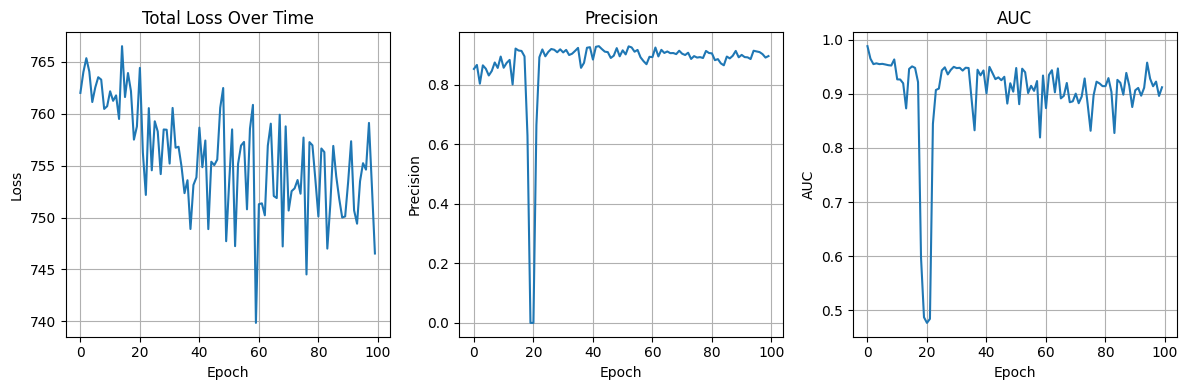

In [ ]:
# Train model
model = train_model(
    customer_df=customer_train,
    article_df=article_train,
    interactions_df=interactions_train,
    epochs=100,
    batch_size=256,
)

# Inference


1. Finding Initial Matches (Retrieval):
  - Turn customer and product information into a tensor for the model
  - Use our trained model to find similarities between customers and products
  - Pick the top k*4 (k defined by us) potential matches for each customer (we get extra since we'll filter some out)

2. Refining the Recommendations:
  - Remove products the customer already bought
  - If we filtered out too many items, look for more potential matches
  - Use our ranking system to score the remaining products
  - Pick the top n best-scoring items as final recommendations

We iterate through different customers and repeat the stps above, using the top-k matches from the first step as our initial recommendations.:

we make sure we don't recommend products someone already owns

This two-step approach helps us efficiently find good matches from thousands of products while keeping recommendations personalized.

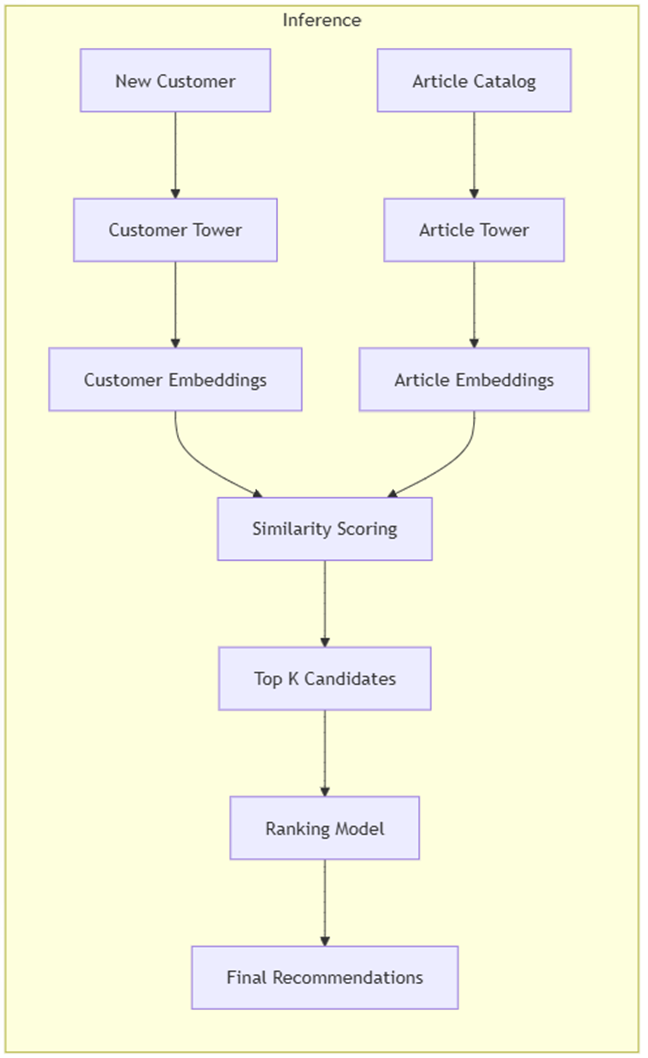

In [79]:

def get_recommendations_multiple_customers(
    model: TwoStageRecommender,
    customer_features,
    article_df,
    interaction_df,
    customer_ids: List[str],
    k = 30
) :
    """
    Get top-k recommendations for multiple customers, excluding their previous purchases.
    

    """
    # customer_ids = [id for id in customer_ids if str(id) != "nan" and str(id) != "-1"]
    # print(f"Number of customers during inference: {len(customer_ids)} \n they are {customer_ids}")

    # Create dictionary of customer purchase histories
    customer_purchases = {
        cust_id: set(interaction_df[interaction_df['customer_id'] == cust_id]['article_id'])
        for cust_id in customer_ids
    }
    
    # Convert customer features to tensor
    customer_features = tf.convert_to_tensor(customer_features.values.astype('float32'))

    
    # Get article features- extract column/features that have "_art" in theor names
    article_features = article_df.filter(regex=".*_art$|.*_art_.*").values
    article_features_tensor = tf.convert_to_tensor(article_features.astype('float32'))

    print(f"**Customer and Items have been converted to tensors.\n Customer features shape: {customer_features.shape} and article features shape: {article_features_tensor.shape}")
    
    # 1- Retrieval: Use the trained retreival model
    customer_embeddings = model.query_model(customer_features)
    article_embeddings = model.candidate_model(article_features_tensor)
    
    # Get initial items using retrieval - this is done with dot product
    retrieval_scores = tf.matmul(customer_embeddings,
        article_embeddings,transpose_b=True)
    
    # Get more initial items since we'll be filtering some out: k*4 is  a padding factor done to get more items
    top_retrieval_scores, top_indices = tf.math.top_k(retrieval_scores,k=k*4)

    print(f"**Retreival done. \n Retrieval scores shape: {top_retrieval_scores.shape} and top indices shape: {top_indices.shape}")
    
    #2 - Ranking
    all_final_scores = []
    all_final_indices = []
    
    # Process each customer separately
    print("Starting to process each customer separately...")
    for customer_index_position, customer_id in enumerate(customer_ids):

        # Get purchased items for this customer
        purchased_items = customer_purchases[customer_id]
        
        # Get item indices for this customer
        candidate_indices = top_indices[customer_index_position].numpy()
        
        # Filter out previously purchased items- We don't want to recommend itesm that the customer has already purchased
        mask = np.array([
            article_df.index[index_position] not in purchased_items 
            for index_position in candidate_indices
        ])
        filtered_indices = candidate_indices[mask]
        
        # Only for exceptions - If we filtered out too many items, get more items
        if len(filtered_indices) < k*2:
            remaining_needed = k*2 - len(filtered_indices)
            _, more_indices = tf.math.top_k(
                retrieval_scores[customer_index_position], 
                k=k*6
            )  # Get even more candidates
            more_indices = more_indices.numpy()
            more_mask = np.array([
                article_df.index[index_position] not in purchased_items 
                for index_position in more_indices
            ])
            more_filtered = more_indices[more_mask]
            filtered_indices = np.unique(
                np.concatenate([filtered_indices, more_filtered])
            )[:k*2]
        
        # Get features for filtered candidates
        candidate_features = tf.gather(article_features_tensor, filtered_indices)
        
        # Repeat current customer's features
        current_customer_features = tf.repeat(
            customer_features[customer_index_position:customer_index_position+1], 
            repeats=[len(candidate_features)], 
            axis=0
        )
        
        # Get ranking scores
        print("**Starting to get ranking scores...")
        ranking_scores = model.ranking_model(current_customer_features, candidate_features)
        
        # Get final top k
        final_k = min(k, len(filtered_indices))
        final_scores, final_indices = tf.math.top_k(ranking_scores[:, 0],k=final_k)
        
        # Pad if necessary (if we couldn't find enough unpurchased items)
        if final_k < k:
            final_scores = tf.pad(final_scores, [[0, k - final_k]])
            final_indices = tf.pad(final_indices, [[0, k - final_k]])
        
        # Map indices back to original article indices
        final_article_indices = tf.gather(filtered_indices, final_indices)
        
        all_final_scores.append(final_scores)
        all_final_indices.append(final_article_indices)
    
    # Stack results for all customers
    print("Stacking results for all customers...")
    final_scores = tf.stack(all_final_scores)
    final_article_indices = tf.stack(all_final_indices)
    
    return final_scores.numpy(), final_article_indices.numpy(), customer_ids



In [ ]:
# Create pre-required datasets
article_df_inference = merge_list_of_datasets([article_train, article_val, article_test])
customer_df_inference = merge_list_of_datasets([customer_train, customer_val, customer_test])

start_position, end_position = 0, 3000

test_customer =  customer_val.filter(regex=".*_cust$|.*_cust_.*").iloc[start_position:end_position]


In [ ]:
# Get recommendations
scores, recommended_article_indices, customer_id_list = get_recommendations_multiple_customers(
    model=model,
    customer_features=test_customer,
    article_df=article_df_inference,
    interaction_df=interactions_val,
    customer_ids=customer_val["customer_id"].iloc[start_position:end_position],
)

**Customer and Items have been converted to tensors.
 Customer features shape: (2420, 23) and article features shape: (15138, 565)
**Retreival done. 
 Retrieval scores shape: (2420, 120) and top indices shape: (2420, 120)
Starting to process each customer separately...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting to get ranking scores...
**Starting

In [ ]:
# Print results
article_ids = article_df_inference[
        "article_id"
    ].values 
predicted_items = article_ids[recommended_article_indices]

for i in range(len(test_customer)):
    print(f"\nCustomer {i}:")
    print(f"Recommendation scores: {scores[i]}")
    print(f"Recommended article : {predicted_items[i]}")


Customer 0:
Recommendation scores: [6.1332597e-05 5.9796734e-05 4.7054451e-05 4.7030851e-05 4.3514345e-05
 3.6705918e-05 3.5615911e-05 3.5477671e-05 3.5275592e-05 3.4409826e-05
 3.4343444e-05 2.9503279e-05 2.7755064e-05 2.6324358e-05 2.6266984e-05
 2.6069089e-05 2.5785319e-05 2.5738369e-05 2.4901485e-05 2.4509072e-05
 2.4417575e-05 2.4201283e-05 2.3903234e-05 2.3769962e-05 2.3609582e-05
 2.3531202e-05 2.2262333e-05 2.2003835e-05 2.1550220e-05 2.0980116e-05]
Recommended article : ['790686007' '793506015' '909911001' '869889001' '781758053' '852748005'
 '917300002' '542533019' '917294002' '685601030' '781758053' '872973002'
 '774043008' '763988013' '790686007' '917293003' '917300002' '917296002'
 '917297002' '536139084' '778645007' '536139084' '778645007' '866660002'
 '935689001' '903813001' '719530014' '698286006' '917300002' '852785003']

Customer 1:
Recommendation scores: [1.07818698e-04 8.20331479e-05 7.91751881e-05 7.14088674e-05
 6.50880393e-05 5.32940794e-05 4.87568323e-05 4.6896

# Recommendation System Evaluation

We evaluate the recommendation system's performance using three standard metrics at K=10, 20, and 30:

1. Evaluation Setup:
  - Creates ground truth from validation transaction data
  - Maps customer IDs to their actual purchases
  - Establishes baseline statistics for comparison

2. Performance Metrics:
  - Precision@K: Accuracy of recommendations
  - Recall@K: Coverage of relevant items
  - NDCG@K: Quality of ranking order

3. Results Analysis:
  - Generates summary metrics across all users
  - Visualizes metric distributions
  - Provides per-customer performance analysis
  - Enables comparison across different K values

The framework offers both aggregate and detailed performance insights, helping identify areas for model improvement.


In [ ]:
class RecommenderEvaluator:
    """ Class for evaluating recommendation models. """
    def __init__(self, test_data):
        self.data = test_data
        self.truth = self.make_truth_dict()
        self.last_results = None
    
    def make_truth_dict(self):
        """ Generate ground truth - map of customer_id to set of article_ids they have purchased. """
        truth = {}
        # Group items by customer
        for _, row in self.data.iterrows():
            if row['customer_id'] not in truth:
                truth[row['customer_id']] = set()
            truth[row['customer_id']].add(row['article_id'])
        return truth
    
    def calc_metrics(self, preds: np.ndarray, real_items: set, k):

        print(f"Calculating metrics for {len(preds)} predictions")
        #Select top k
        preds = preds[:k]  
        hits = len(set(preds) & real_items)
        
        # Calculate precision and recall
        prec = hits / k if k > 0 else 0
        rec = hits / len(real_items) if real_items else 0
        
        # NDCG
        rel = [1 if p in real_items else 0 for p in preds]
        dcg = rel[0] if rel else 0
        for i in range(1, len(rel)):
            dcg += rel[i] / np.log2(i + 2)
        
        # Ideal DCG just uses all 1s
        ideal_rel = [1] * min(k, len(real_items))
        idcg = ideal_rel[0] if ideal_rel else 0
        for i in range(1, len(ideal_rel)):
            idcg += 1 / np.log2(i + 2)
            
        ndcg = dcg / idcg if idcg > 0 else 0
        
        return {
            f'p@{k}': prec,
            f'r@{k}': rec,
            f'ndcg@{k}': ndcg
        }
    
    def evaluate(self, all_preds, customers, ks=[10,20]):
        """ Evaluate recommendations for multiple users at different k values. 
        Runs calculate_metrics on each user. """
        results = {'by_user': {}, 'avg': {}}
        
        # Loop through each customer
        for idx, cust in enumerate(customers):
            if cust not in self.truth:
                continue
                
            user_results = {}
            preds = all_preds[idx]
            true_items = self.truth[cust]
            # print(f" True set of type {type(true_items)}")

            
            # Get metrics for each k
            for k in ks:
                metrics = self.calc_metrics(preds, true_items, k)
                user_results.update(metrics)
            
            results['by_user'][cust] = user_results
        
        # Calculate averages
        all_metrics = {}
        for k in ks:
            p = [u[f'p@{k}'] for u in results['by_user'].values()]
            r = [u[f'r@{k}'] for u in results['by_user'].values()]
            n = [u[f'ndcg@{k}'] for u in results['by_user'].values()]
            
            all_metrics[f'precision@{k}'] = np.mean(p)
            all_metrics[f'recall@{k}'] = np.mean(r) 
            all_metrics[f'ndcg@{k}'] = np.mean(n)
        
        results['avg'] = all_metrics
        del results['by_user']
        self.last_results = results
        return results
    
    def get_report(self):
        if not self.last_results:
            return "No results yet! Run evaluate first."
            
        # Just return averages as dataframe
        return pd.DataFrame({
            'metric': list(self.last_results['avg'].keys()),
            'value': list(self.last_results['avg'].values())
        })

In [47]:
evaluator = RecommenderEvaluator(interactions_val)
results = evaluator.evaluate(predicted_items, customer_id_list, ks=[10, 20])
results_df = evaluator.get_report()

Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 30 predictions
Calculating metrics for 3

In [ ]:
# Print Evaluation metrics

print(f"The evaluation results:\n {results_df}")

The evaluation results:
     metric     value
0     p@10  0.600000
1     r@10  0.001722
2  ndcg@10  0.791727
3     p@20  0.550000
4     r@20  0.003157
5  ndcg@20  0.688706


### The End